In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, OPTICS
from numba import jit
import os
from pathlib import Path
from scipy.spatial import distance_matrix
import multiprocessing as mp

In [3]:
def read_bl2(path):
    return np.core.records.fromfile(str(path),formats='f8,(2048)i2,f8,(2048)i2',names='tstamp,pwave,ptime,wave')

In [4]:
saturatedData = np.array(np.arange(2048))
# List all files in directory using pathlib
basepath = Path("/Users/elicarter/Local/FominResearch/RealData/Runs/s_1000")
files_in_basepath = (entry for entry in basepath.iterdir() if entry.is_file())
for item in files_in_basepath:
    if str(item).endswith(".dat"):
        saturatedData = np.vstack((saturatedData, read_bl2(item)["wave"]))
saturatedData = np.delete(saturatedData, [0], 0) #delete the placeholder shape row

In [5]:
#delete all data that goes over 30,000 as it's pre amp saturated
data = np.copy(saturatedData)
over30k = False
#iterate backwards to avoid index proboems with removing
for i in range(len(saturatedData)-1,-1,-1):
    for j in range(len(saturatedData[0])-1,-1,-1):
        if (saturatedData[i,j] > 30000):
            data = np.delete(data, i, axis=0)
            break

In [6]:
np.random.shuffle(data)
print(np.shape(saturatedData))
print(np.shape(data))

(8590, 2048)
(8554, 2048)


# Dimensionality Reduction using principal component analysis¶

In [7]:
u, s, vh = np.linalg.svd(data, full_matrices=False)

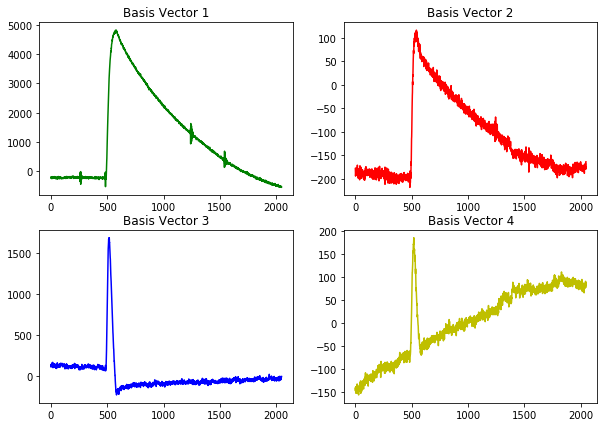

In [8]:
fig, ax = plt.subplots(2,2, figsize = (10,7))
ax[0,0].plot(u[0,0]*s[0]*vh[0], color = 'g')
ax[0,0].title.set_text("Basis Vector 1")
ax[0,1].plot(u[1,1]*s[1]*vh[1], color = 'r')
ax[0,1].title.set_text("Basis Vector 2")
ax[1,0].plot(u[2,2]*s[2]*vh[2], color = 'b')
ax[1,0].title.set_text("Basis Vector 3")
ax[1,1].plot(u[3,3]*s[3]*vh[3], color = 'y')
ax[1,1].title.set_text("Basis Vector 4")

use scree plot and percent variance to find where we should make the cut on demensions

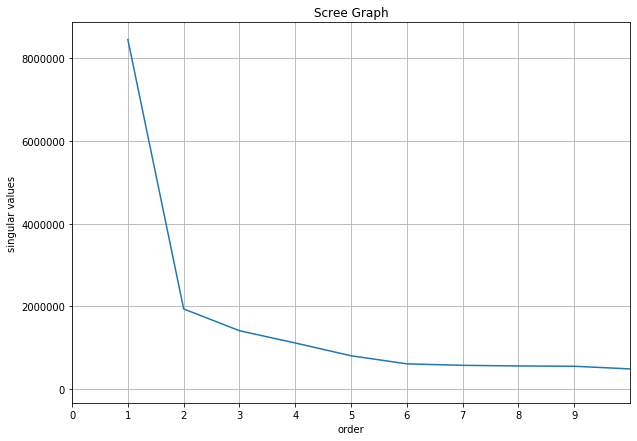

In [9]:
scree_order = np.arange(1,len(s)+1)
fig, ax = plt.subplots(1, 1, figsize = (10,7))
ax.plot(scree_order, s)
ax.title.set_text("Scree Graph")
ax.set_ylabel("singular values")
ax.set_xlabel("order")
ax.set_xlim([0,10])
ax.set_xticks(np.arange(0,10))
plt.grid()
plt.show()

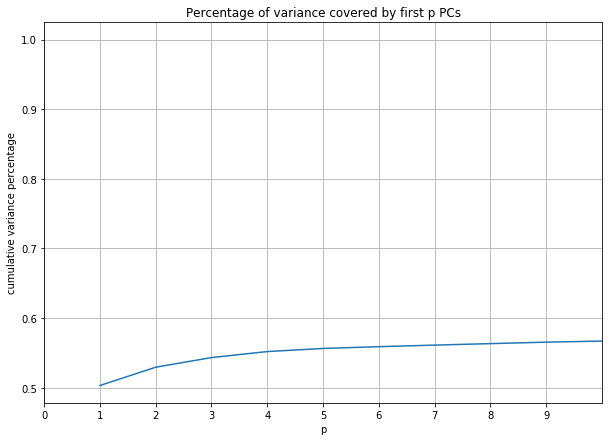

In [10]:
variance = np.zeros_like(s)
for i in range(len(s)):
    variance[i] = s[i]**2
total_variance = 0
for i in range(len(variance)):
    total_variance += variance[i]
    
pvc = np.zeros_like(variance)
for i in range(len(pvc)):
    pvc[i] = variance[i] + pvc[i-1]
for i in range(len(pvc)):
    pvc[i] = pvc[i] / total_variance
    
fig, ax = plt.subplots(1, 1, figsize = (10,7))
ax.plot(scree_order, pvc)
ax.title.set_text('Percentage of variance covered by first p PCs')
ax.set_xlabel('p')
ax.set_ylabel('cumulative variance percentage')
ax.set_xlim(0,10)
ax.set_xticks(np.arange(0,10))
plt.grid()
plt.show()

In [11]:
v = np.transpose(vh)
v2D = v[:,:2]
v5D = v[:,:5]

rData2D = data@v2D
rData5D = data@v5D

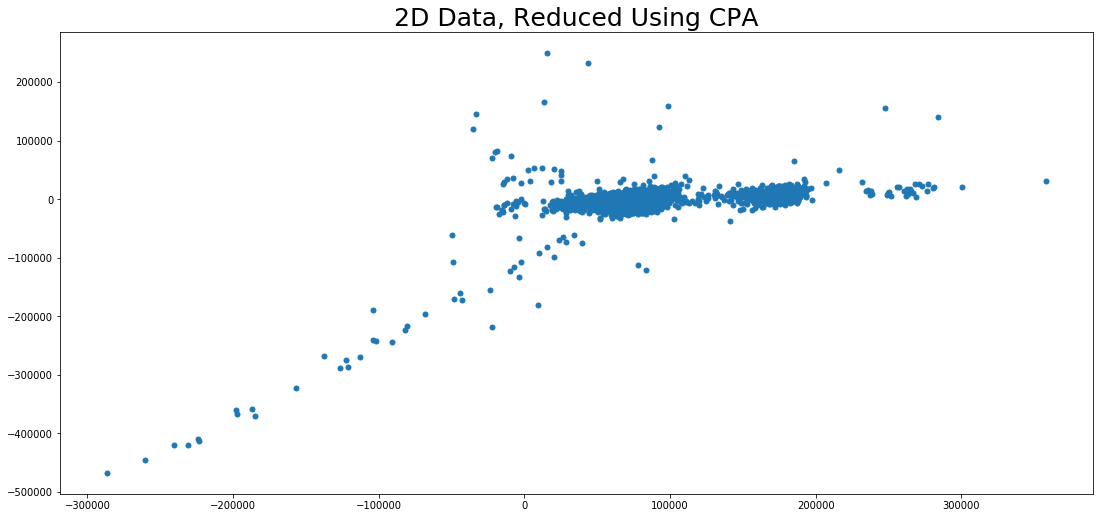

In [12]:
plt.scatter(rData2D[:,0], rData2D[:,1], s=25)
#plt.axis("equal")
fig = plt.title("2D Data, Reduced Using CPA", fontsize=25)
fig = plt.gcf()
fig.set_size_inches(18.5, 8.5)

# Start OPTICS

In [13]:
pltColors = ["r.", "g.", "b.", "c.", "m."]
colors = {}
colors[-1] = 'black'
colors[0] = 'r'
colors[1] = 'g'
colors[2] = 'b'
colors[3] = 'c'
colors[4] = 'm'
colors[5] = 'y'
colors[6] = 'pink'
colors[7] = 'purple'
colors[8] = 'silver'
colors[9] = 'brown'
colors[10] = 'olive'
colors[11] = 'aquamarine'
colors[12] = 'cornflowerblue'
colors[13] = 'teal'
colors[14] = 'salmon'
colors[15] = 'lime'
colors[16] = 'gold'

In [14]:
doubleDistances2 = distance_matrix(rData2D, rData2D)
#double counts distances. Get upper triangle matrix then manipulate it 
temp2 = np.triu(doubleDistances2)
distances2 = np.asarray(temp2).reshape(-1)
distances2 = np.sort(distances2)
distances2 = np.flip(distances2)
#remove 0s where repeats used to be
nonzeros = int((len(doubleDistances2)*len(doubleDistances2) - 1)/2)
distances2 = distances2[0:nonzeros]
order = np.arange

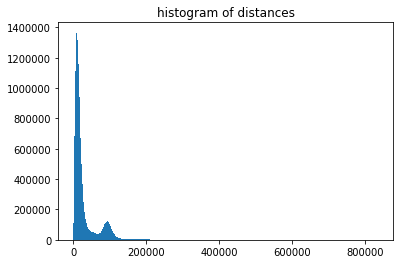

In [15]:
plt.title("histogram of distances")
fig11 = plt.hist(distances2, 1000)

(0, 20000)

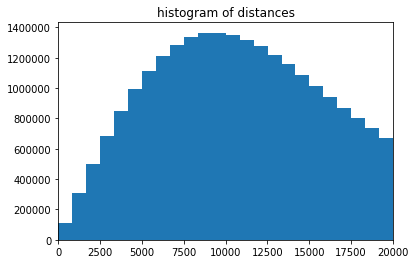

In [16]:
plt.title("histogram of distances")
fig11 = plt.hist(distances2, 1000)
plt.xlim(0,20000)

In [17]:
#optics dbscan
o2 = OPTICS(min_samples=5, eps=6000, cluster_method="dbscan").fit(rData2D)
space2 = np.arange(len(rData2D))
reachability2 = o2.reachability_[o2.ordering_]
labels2 = o2.labels_[o2.ordering_]
n_clusters2 = len(np.delete(np.unique(labels2), 0))

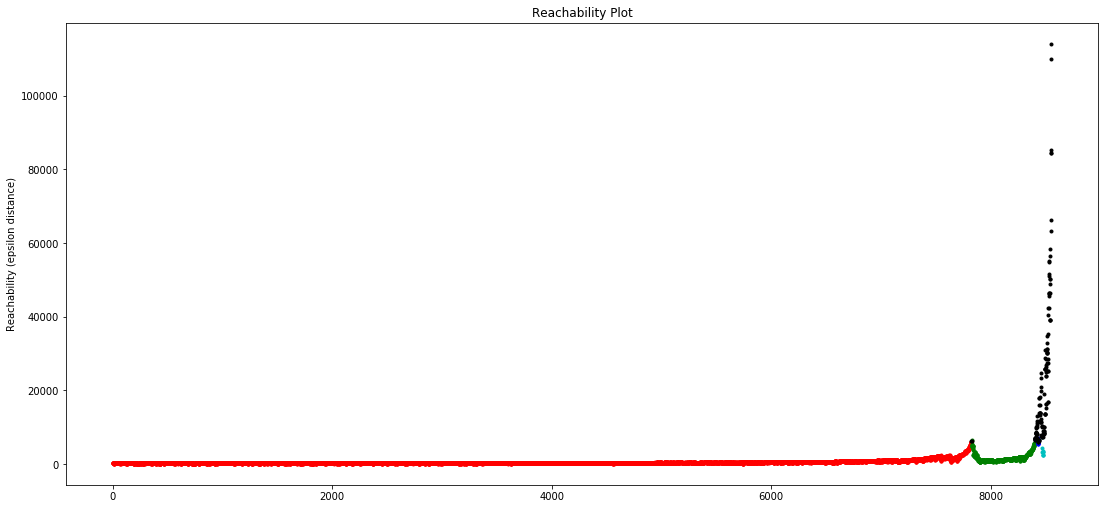

In [18]:
#reachability
for klass, color in zip(range(0, 5), pltColors):
    Xk = space2[labels2 == klass]
    Rk = reachability2[labels2 == klass]
    plt.plot(Xk, Rk, color, alpha=1)
plt.plot(space2[labels2 == -1], reachability2[labels2 == -1], "k.", alpha=1)
plt.ylabel('Reachability (epsilon distance)')
plt.title('Reachability Plot')
fig = plt.gcf()
fig.set_size_inches(18.5, 8.5)

(0, 20000)

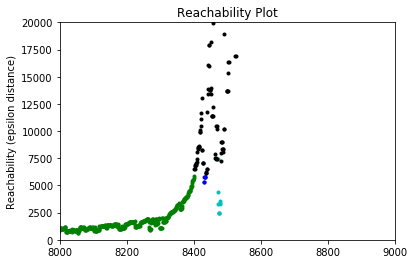

In [19]:
#zoomed reachability
for klass, color in zip(range(0, 5), pltColors):
    Xk = space2[labels2 == klass]
    Rk = reachability2[labels2 == klass]
    plt.plot(Xk, Rk, color, alpha=1)
plt.plot(space2[labels2 == -1], reachability2[labels2 == -1], "k.", alpha=1)
plt.ylabel('Reachability (epsilon distance)')
plt.title('Reachability Plot')
plt.xlim(8000, 9000)
plt.ylim(0, 20000)

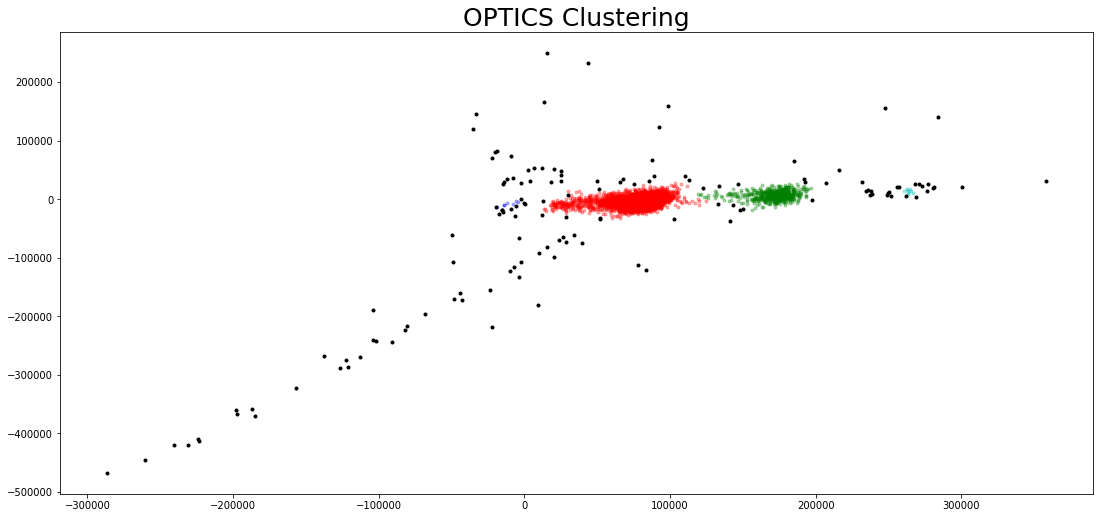

In [22]:
for klass, color in zip(range(0, 5), pltColors):
    Xk = rData2D[o2.labels_ == klass]
    plt.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
plt.plot(rData2D[o2.labels_ == -1, 0], rData2D[o2.labels_ == -1, 1], 'k.')
plt.title('OPTICS Clustering', fontsize=25)
fig = plt.gcf()
fig.set_size_inches(18.5, 8.5)

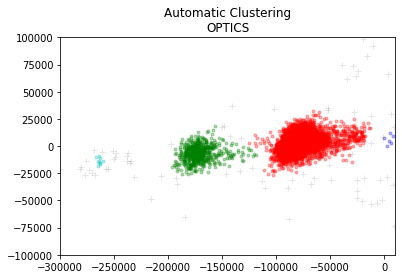

In [20]:
for klass, color in zip(range(0, 5), pltColors):
    Xk = rData2D[o2.labels_ == klass]
    plt.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
plt.plot(rData2D[o2.labels_ == -1, 0], rData2D[o2.labels_ == -1, 1], 'k+', alpha=0.1)
plt.title('Automatic Clustering\nOPTICS')
plt.xlim(-300000, 10000, auto=False)
plt.ylim(-100000, 100000, auto=False)
plt.show()

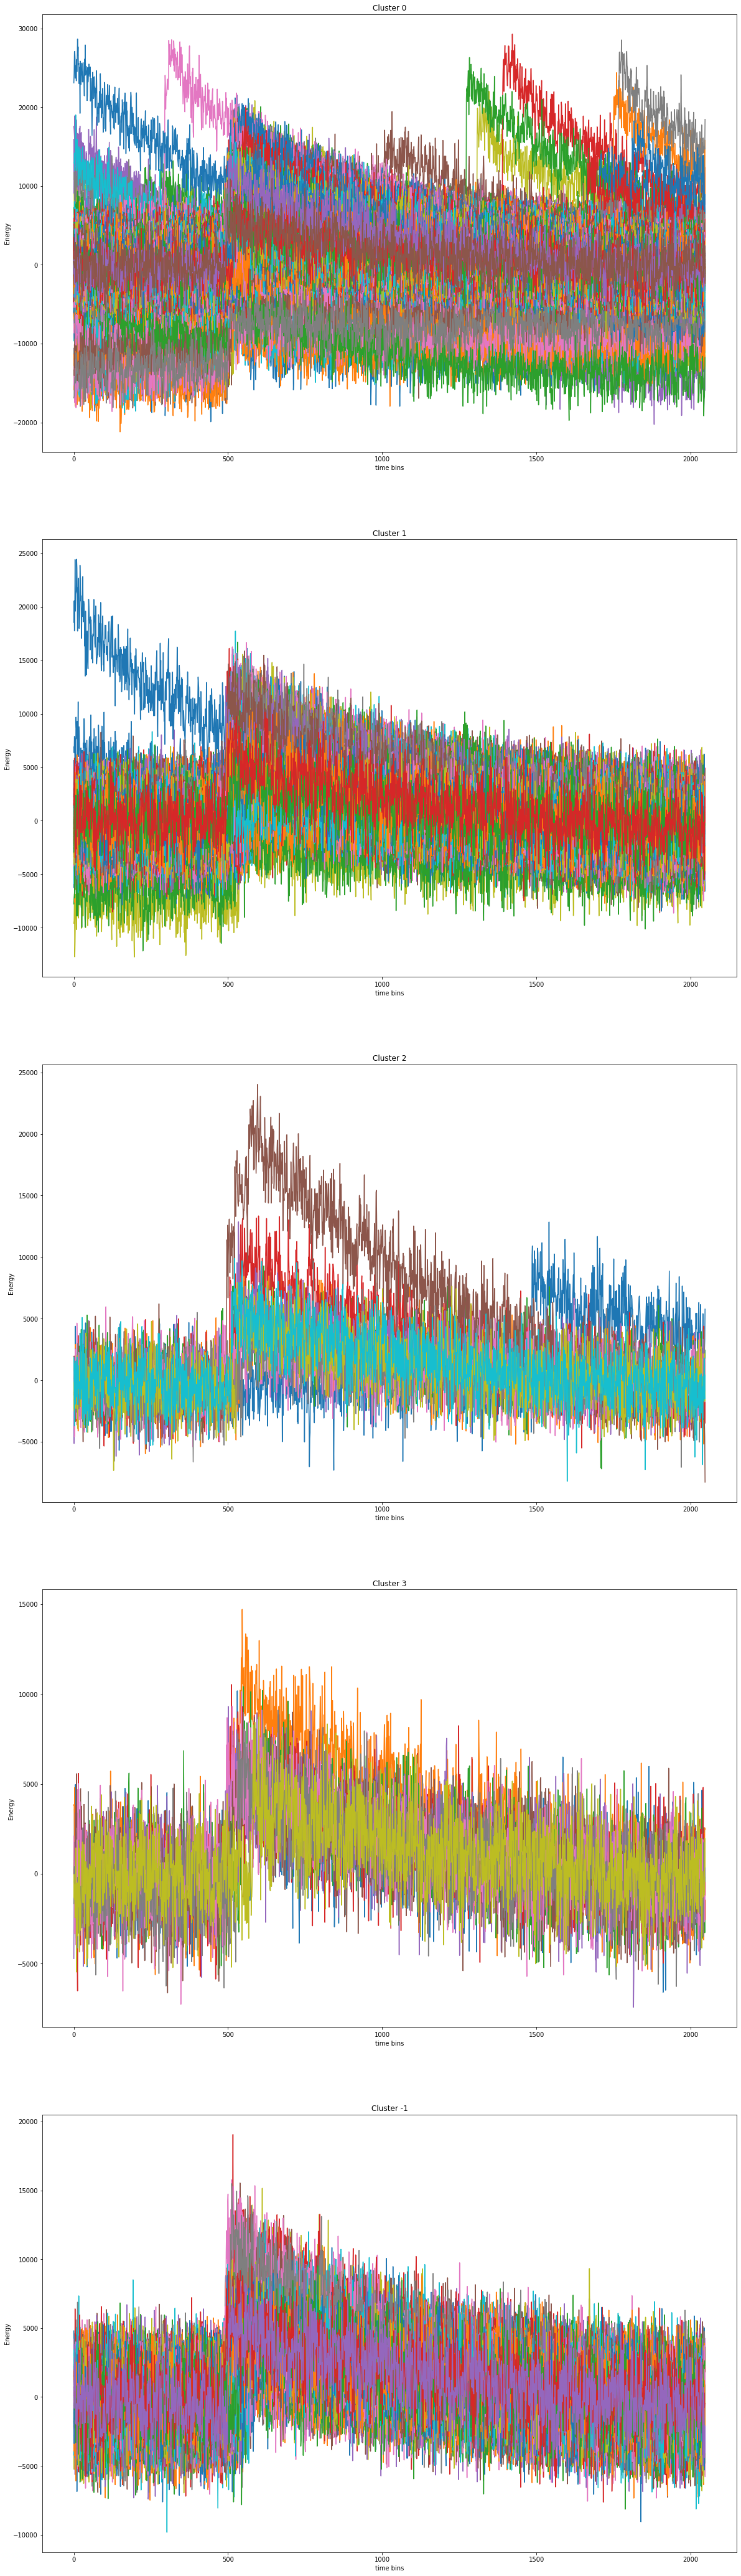

In [21]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots(n_clusters2+1, figsize = (20,75))
t = np.arange(2048)
for n in range(len(labels2)):
    for i in range(-1, n_clusters2):
        if i == labels2[n]:
            ax[i].plot(t, data[n])
            ax[i].title.set_text("Cluster " + str(i))
            ax[i].set_xlabel("time bins")
            ax[i].set_ylabel("Energy")
for i in range(n_clusters2):
        text_x = ax[i].get_xlim()[1] - 0.4*(ax[i].get_xlim()[1] - ax[i].get_xlim()[0])
        text_y = ax[i].get_ylim()[1] - 0.1*(ax[i].get_ylim()[1] - ax[i].get_ylim()[0])
plt.show()